# Loads packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.optim as optim
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
import sys,os
sys.path.append(os.path.realpath('./src/'))
import pandas as pd
from materialEncoder import MaterialEncoder
import time
import itertools

# Loads the database

In [2]:
def preprocessData():
  df = pd.read_excel('./data/MaterialDatabase_FULL.xlsx')# # 
  dataIdentifier = {'name': df[df.columns[0]], 'className':df[df.columns[1]], 'classID':df[df.columns[2]]} # name of the material and type
  trainInfo = torch.tensor((df[df.columns[3:]].to_numpy())).float()

  return dataIdentifier, trainInfo, df
dataIdentifier, trainInfo, df = preprocessData()

props = df.columns[3:].tolist()
nmat, nprop = trainInfo.size()

# Loads the truss

In [3]:
from examples import getExample
from trussFE import TrussFE

#Loads the example truss
exampleName, nodeXY, connectivity, bc = getExample(4)
#Changes the force
bc['forces'] = {'nodes':np.array([2]), 'fx':1.E3*torch.tensor([0.]), 'fy':1.E2*torch.tensor([125.])}


#Loads the truss in truss
truss = TrussFE(nodeXY, connectivity, bc)

# Sets the constraints and objectives

In [4]:
#Defines constraints and objectives
constraints = {'massCons': {'isOn':False, 'maxMass':5}, \
               'costCons': {'isOn':False, 'maxCost':5},\
               'tensionCons': {'isOn':True, 'FOS':4.},\
               'complianceCons': {'isOn':False, 'maxJ':35},\
               'compressionCons': {'isOn':True, 'FOS':4.},\
               'co2Cons': {'isOn':False, 'maxco2':30},\
               'energyCons': {'isOn':False, 'maxenergy' : 1e10},\
               'waterCons': {'isOn':False, 'maxwater':4e3}}


objectives = {'cost': {'isOn':False},\
              'mass': {'isOn':True}, \
              'co2': {'isOn':False},\
              'water': {'isOn':False},\
              'energy': {'isOn':False},\
              'compliance': {'isOn': False}}
               
# count the number of entries with 'isOn' set to True
no = sum(1 for v in objectives.values() if v['isOn'])
nc = sum(1 for v in constraints.values() if v['isOn'])

# print an error message in red if there are 3 or more entries with 'isOn' set to True
if no >= 3:
    print('Error: Three or more entries have isOn=True')



# Defines the problem

In [5]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem



#Problem of minimizing mass with the tensile and compressio constraints. We have 2 variables of the latent space constrained
#to the limits in the map and 6 areas with limits.
class MyProblem_fix(ElementwiseProblem):

    def __init__(self,truss, matprop, constraints, objectives, nc, no):
        super().__init__(n_var=6,
                         n_obj=no,
                         n_ieq_constr=nc,
                         xl=np.array([2e-6, 2e-6, 2e-6, 2e-6, 2e-6, 2e-6]),
                         xu=np.array([2e-2, 2e-2, 2e-2, 2e-2, 2e-2, 2e-2]))

        self.truss=truss
        self.matprop=matprop
        self.constraints=constraints
        self.objectives=objectives

    def _evaluate(self, x, out, *args, **kwargs):

        x_tensor = torch.from_numpy(x)
        area = x_tensor * torch.ones((connectivity.shape[0]))   
        u, _, _, _, internalForce = truss.solveFE(E = torch.tensor([matprop[0]]).float(), A=area)
        compliance = truss.computeCompliance(u)
        volume = truss.getVolume(area)
        mass = matprop[2]*volume
        cost = mass*matprop[1]
        co2 = mass*matprop[4]
        energy = mass*matprop[5]        
        water = mass*matprop[6] 
        
        
        con_values = []
        
        if(constraints['massCons']['isOn']):
            constraints['massCons']['value'] = (mass/constraints['massCons']['maxMass']) - 1.
            con_values.append(constraints['massCons']['value'])

        if(constraints['costCons']['isOn']):
            constraints['costCons']['value'] = (cost/constraints['costCons']['maxCost']) - 1.
            con_values.append(constraints['costCons']['value'])

        if(constraints['tensionCons']['isOn']):
            tensileForce = 0.001+torch.relu(internalForce)
            tensileStress = tensileForce/area
            maxTensileStressExperienced = torch.pow(torch.sum(tensileStress**6), 1./6)*constraints['tensionCons']['FOS']
            constraints['tensionCons']['value'] = (maxTensileStressExperienced/matprop[3]) - 1.
            con_values.append(constraints['tensionCons']['value'])

        if(constraints['complianceCons']['isOn']):
            constraints['complianceCons']['value'] = (compliance/constraints['complianceCons']['maxJ']) - 1.
            con_values.append(constraints['complianceCons']['value'])

        if(constraints['compressionCons']['isOn']):
            compressiveForce = 0.001+torch.relu(-internalForce)
            k = 4. # used in geom factor... see buckling theory
            geomFactor = k*(self.truss.barLength/(np.pi*area))**2
            compressiveStress = compressiveForce*geomFactor
            maxCompressiveStressExperienced = torch.pow(torch.sum(compressiveStress**6), 1./6)*constraints['compressionCons']['FOS']
            constraints['compressionCons']['value'] = (maxCompressiveStressExperienced/matprop[0]) - 1.
            con_values.append(constraints['compressionCons']['value'])

        if(constraints['co2Cons']['isOn']):
            constraints['co2Cons']['value'] = (co2/constraints['co2Cons']['maxco2']) - 1.
            con_values.append(constraints['co2Cons']['value'])

        if(constraints['energyCons']['isOn']):
            constraints['energyCons']['value'] = (energy/constraints['energyCons']['maxenergy']) - 1.
            con_values.append(constraints['energyCons']['value'])

        if(constraints['waterCons']['isOn']):
            constraints['waterCons']['value'] = (water/constraints['waterCons']['maxwater']) - 1.
            con_values.append(constraints['waterCons']['value'])
            
        
        
        obj_values = []
        
        if(objectives['cost']['isOn']):
            obj_values.append(cost)
            
        if(objectives['mass']['isOn']):
            obj_values.append(mass)
            
        if(objectives['co2']['isOn']):
            obj_values.append(co2)
            
        if(objectives['water']['isOn']):
            obj_values.append(water)
            
        if(objectives['energy']['isOn']):
            obj_values.append(energy)
            
        if(objectives['compliance']['isOn']):
            obj_values.append(compliance)            
  

        out["F"] = np.array(obj_values)
        out["G"] = np.array(con_values)



algorithm_fix = NSGA2(
    pop_size=40,
    n_offsprings=20,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)


termination_fix = DefaultMultiObjectiveTermination(
    xtol=1e-7,
    cvtol=1e-6,
    ftol=0.01,
    period=10,
    n_max_gen=1000,
    n_max_evals=50000
)


# Runs the solver

In [8]:
N=nmat
results = np.empty((N, 5))
areas = np.empty((N, 6))
names = []
types = []


start = time.perf_counter()
for i in range(N):

    matlist=[i for i in range(N)]
    matprop=trainInfo[i,:]
    print(i)
    res = minimize(MyProblem_fix(truss, matprop, constraints, objectives, nc, no),
               algorithm_fix,
               termination_fix,
               seed=1,
               save_history=False,
               verbose=False)
    results[i,1] = np.hstack(res.F) #mass
    results[i,0] = results[i,1]*matprop[1] #cost
    results[i,2] = results[i,1]*matprop[4] #co2
    results[i,3] = results[i,1]*matprop[5] #energy
    results[i,4] = results[i,1]*matprop[6] #water
    areas[i] = np.hstack(res.X)
    
    
    matname = dataIdentifier['name'][i]
    mattype = dataIdentifier['className'][i]
    names.append(matname)
    types.append(mattype)
print('Solver time : {:.2F}'.format(time.perf_counter() - start))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
Solver time : 321.14


# Cost vs mass

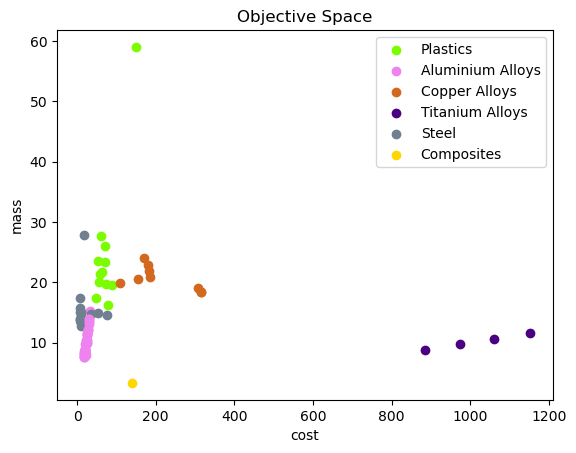

In [9]:
objectivesx = {'cost': {'isOn':True}, \
              'mass': {'isOn':True}, \
              'co2': {'isOn':False}, \
              'water': {'isOn':False}, \
              'energy': {'isOn':False}, \
              'compliance': {'isOn': False}}

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

# Create scatter plot
fig, ax = plt.subplots()
for i in range(len(results)):
    x = results[i][0]
    y = results[i][1]
    label = names[i]
    material_type = types[i]
    color = mat_colors.get(material_type, (0.8, 0.8, 0.8))
    ax.scatter(x, y, color=color, label=material_type)
    #ax.text(x + 0.1, y + 0.1, label)

# Add legend and axis labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# show plot
plt.title("Objective Space")

entry_order = ['cost', 'mass', 'co2', 'water', 'energy']
enabled_entries = []

for entry in entry_order:
    if objectivesx[entry]['isOn']:
        enabled_entries.append(entry)

ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Bruteforce/brute_costvsmass.png', bbox_inches='tight', dpi=200)
plt.show()

# Plots Pareto

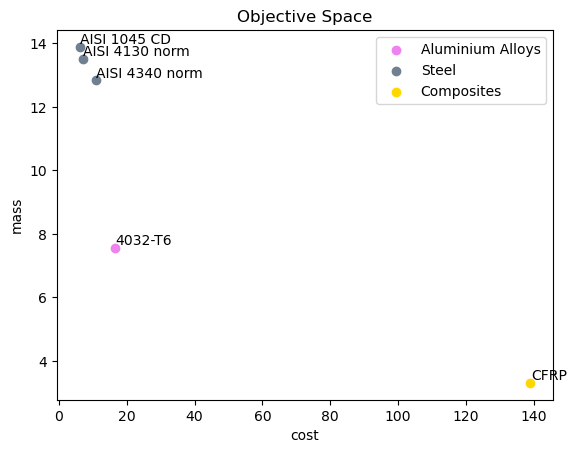

In [10]:
# Step 1: Extract x (cost) and y (mass) values from results
x_values = [result[0] for result in results]
y_values = [result[1] for result in results]

# Step 2: Identify non-dominated points to get Pareto front
pareto_front_indices = []
for i in range(len(x_values)):
    is_dominated = False
    for j in range(len(x_values)):
        if i == j:
            continue
        if x_values[i] >= x_values[j] and y_values[i] >= y_values[j]:
            is_dominated = True
            break
    if not is_dominated:
        pareto_front_indices.append(i)

# Step 3: Plot the Pareto front materials in a scatter plot
fig, ax = plt.subplots()
for i in pareto_front_indices:
    x = x_values[i]
    y = y_values[i]
    label = names[i]
    material_type = types[i]
    color = mat_colors.get(material_type, (0.8, 0.8, 0.8))
    ax.scatter(x, y, color=color, label=material_type)
    ax.text(x + 0.1, y + 0.1, label)

# Add legend and axis labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# Show plot with only the Pareto front materials
plt.title("Objective Space")

entry_order = ['cost', 'mass', 'co2', 'water', 'energy']
enabled_entries = [entry for entry in entry_order if objectivesx[entry]['isOn']]

ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Bruteforce/brute_costvsmass_pareto.png', bbox_inches='tight', dpi=200)
plt.show()

# Cost vs CO2

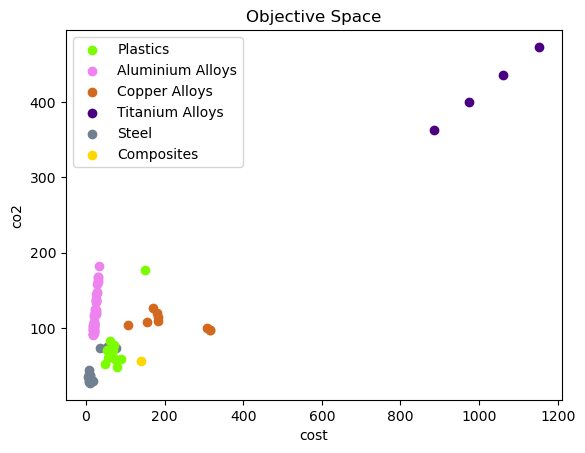

In [11]:
objectivesx = {'cost': {'isOn':True}, \
              'mass': {'isOn':False}, \
              'co2': {'isOn':True}, \
              'water': {'isOn':False}, \
              'energy': {'isOn':False}, \
              'compliance': {'isOn': False}}

# Define specific colors for each material type
mat_colors = {
    'Steel': 'slategrey',
    'Aluminium Alloys': 'violet',
    'Plastics': 'lawngreen',
    'Titanium Alloys': 'indigo',
    'Copper Alloys': 'chocolate',
    'Composites': 'gold',
    # Add more material types and corresponding colors as needed
}

# Create scatter plot
fig, ax = plt.subplots()
for i in range(len(results)):
    x = results[i][0]
    y = results[i][2]
    label = names[i]
    material_type = types[i]
    color = mat_colors.get(material_type, (0.8, 0.8, 0.8))
    ax.scatter(x, y, color=color, label=material_type)
    #ax.text(x + 0.1, y + 0.1, label)

# Add legend and axis labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# show plot
plt.title("Objective Space")

entry_order = ['cost', 'mass', 'co2', 'water', 'energy']
enabled_entries = []

for entry in entry_order:
    if objectivesx[entry]['isOn']:
        enabled_entries.append(entry)

ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Bruteforce/brute_costvsco2.png', bbox_inches='tight', dpi=200)
plt.show()

# Plots Pareto

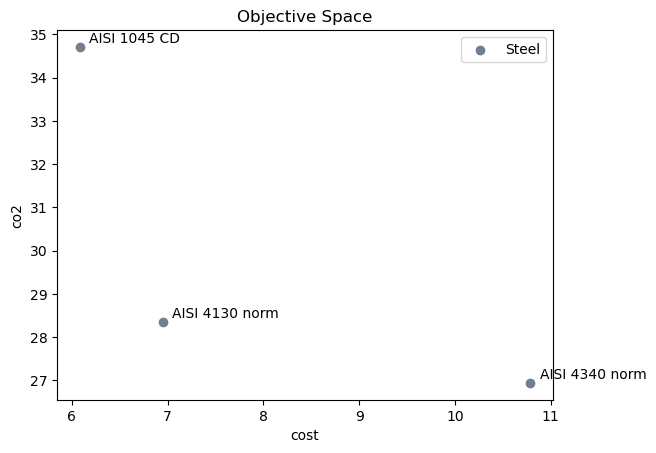

In [12]:
# Step 1: Extract x (cost) and y (mass) values from results
x_values = [result[0] for result in results]
y_values = [result[2] for result in results]

# Step 2: Identify non-dominated points to get Pareto front
pareto_front_indices = []
for i in range(len(x_values)):
    is_dominated = False
    for j in range(len(x_values)):
        if i == j:
            continue
        if x_values[i] >= x_values[j] and y_values[i] >= y_values[j]:
            is_dominated = True
            break
    if not is_dominated:
        pareto_front_indices.append(i)

# Step 3: Plot the Pareto front materials in a scatter plot
fig, ax = plt.subplots()
for i in pareto_front_indices:
    x = x_values[i]
    y = y_values[i]
    label = names[i]
    material_type = types[i]
    color = mat_colors.get(material_type, (0.8, 0.8, 0.8))
    ax.scatter(x, y, color=color, label=material_type)
    ax.text(x + 0.1, y + 0.1, label)

# Add legend and axis labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels)

# Show plot with only the Pareto front materials
plt.title("Objective Space")

entry_order = ['cost', 'mass', 'co2', 'water', 'energy']
enabled_entries = [entry for entry in entry_order if objectivesx[entry]['isOn']]

ax.set_xlabel(enabled_entries[0])
ax.set_ylabel(enabled_entries[1])
plt.savefig('./figures_Bruteforce/brute_costvsco2_pareto.png', bbox_inches='tight', dpi=200)
plt.show()